In [197]:
import os 
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from PIL import Image 

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import random

# from posteriors import Diffusion_Coefficients, BrownianPosterior_Coefficients, get_time_schedule
from sampling_utils import extract
from typing import List, Optional, Dict

In [198]:
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math

class Checkerboard(Dataset):
    def __init__(self, size=8, grid_size=4):
        self.size = size
        self.grid_size = grid_size
        self.checkboard = torch.tensor([[i, j] for i in range(grid_size) for j in range(grid_size) if (i + j) % 2 == 0])

        grid_pos = torch.randint(low=0, high=self.checkboard.shape[0], size=(self.size,), dtype=torch.int64)
        self.data = torch.rand(size=(self.size, 2), dtype=torch.float32) + self.checkboard[grid_pos].float()
        self.data = self.data / self.grid_size * 2 - 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]


class Pinwheel(Dataset):
    def __init__(self, size: int):
        self.size = size

        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 8
        num_per_class = math.ceil(size / num_classes)
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = np.random.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))
        x = .4 * np.random.permutation(np.einsum("ti,tij->tj", features, rotations))

        self.init_sample = torch.from_numpy(x).float()

    def __len__(self):
        return self.size

    def __getitem__(self, idx: int) -> Tensor:
        return self.init_sample[idx]


data_size = 2 ** 15
pinwheel_dataset = Pinwheel(data_size)
checkerboard_dataset = Checkerboard(size=data_size)

In [199]:
batch_size = 2 ** 10
pinwheel_data_loader = DataLoader(pinwheel_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)
checkerboard_data_loader = DataLoader(checkerboard_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)

def show_2d_data(data: Tensor):
    plt.figure(figsize=(3, 3))
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()
    plt.close()

In [200]:
pinwheel_batch = next(iter(pinwheel_data_loader))
checkerboard_batch = next(iter(checkerboard_data_loader))

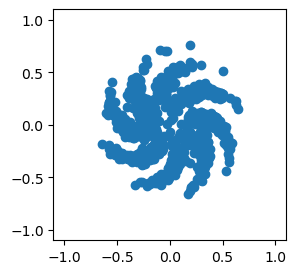

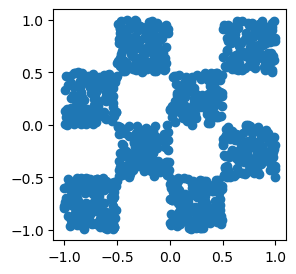

In [201]:
show_2d_data(next(iter(pinwheel_data_loader)))
show_2d_data(next(iter(checkerboard_data_loader)))

$\varepsilon$ 是布朗桥强度

对于离散的情况

从$x_0$和$x_1$的联合分布中采样$(x_0, x_1)$, 然后得出条件化的布朗桥

$$

p^{W^\varepsilon}(x_{t_1}\ldots x_{t_N} | x_0, x_1) = \prod_{i=1}^{N} p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) \\

p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) = \mathcal{N}(x_{t_i}; x_{t_{i-1}} + \frac{t_i - t_{i-1}}{1 - t_{i-1}}(x_1 - x_{t_{i-1}}),\varepsilon \frac{(t_i - t_{i-1})(1 - t_i)}{(1 - t_{i-1})} I)\\

p^{W^\varepsilon}(x_{t_{i}} | x_{t_{i+1}}, x_1) = \mathcal{N}(x_{t_i}; \frac{t_{i+1}-t_{i}}{t_{i+1}} x_0 + \frac{t_{i}}{t_{i+1}} x_{t_{i+1}},\varepsilon \frac{t_i(t_{i+1} - t_{i})}{t_{i+1}} I)\\

p^{W^\varepsilon}(x_{t_N} | x_0, x_1) = \mathcal{N}(x_{t_N}; (1 - t_N) x_0 + t_N x_1, \varepsilon t_N(1 - t_N) I)

$$

MSBM训练:

我们假定有N个均匀时间网格

$$
t_0 =0 \lt t_1 \lt \cdots \lt t_N = 1
$$

然后我们给定$m+1$个边界限定
$$
t_{k_0} = 0 \lt t_{k_1} \lt \cdots \lt t_{k_m} = 1, 
$$
Let $N_j= k_{j+1}-k_j$.

在第$j$段内，我们引入局部归一化时间:
$$
\tau_i = \frac{i}{N_j},\quad i=0,\ldots,N_j.
$$
这样在内部套用ASBM的布朗桥系数公式


In [202]:
class SegmentPosterior:
    """
    一段 [k_j, k_{j+1}] 内部用到的局部布朗桥系数与便捷采样。
    """
    
    def __init__(self, N_j: int, epsilon: float, device):
        self.N_j = N_j
        self.epsilon = epsilon
        t = torch.linspace(0, 1, N_j+1, device=device)  # 段内局部时间
        self.posterior_mean_coef1 = 1 - t[:-1]/t[1:]    # for x_left
        self.posterior_mean_coef2 = t[:-1]/t[1:]        # for x_{t+1}
        var = epsilon * t[:-1]*(t[1:]-t[:-1]) / t[1:]
        self.posterior_log_variance = torch.log(var.clamp(min=1e-20))
        self.tau_tp1 = (torch.arange(N_j, device=device, dtype=torch.float32)+1.0)/float(N_j)

    def sample_bridge_tp1(self, x_left, x_right, local_i):
        """采样 x_{t+1}（段内第 i->i+1 步的右端）"""
        tau = self.tau_tp1[local_i].unsqueeze(-1)
        mean = (1. - tau) * x_left + tau * x_right
        var = self.epsilon * tau * (1. - tau)
        noise = torch.randn_like(x_left)
        mask = (tau>0) & (tau<1)
        return mean + mask * torch.sqrt(var.clamp_min(1e-20)) * noise

    def sample_posterior_t(self, x_left, x_tp1, local_i):
        """采样 x_t ~ q(x_t | x_{t+1}, x_left)（段内单步后验）"""
        a = self.posterior_mean_coef1[local_i].unsqueeze(-1)  # coef for x_left
        b = self.posterior_mean_coef2[local_i].unsqueeze(-1)  # coef for x_{t+1}
        mean = a * x_left + b * x_tp1
        logv = self.posterior_log_variance[local_i].unsqueeze(-1)
        noise = torch.randn_like(x_tp1)
        nonzero = (local_i > 0).float().unsqueeze(-1)
        return mean + nonzero * torch.exp(0.5*logv) * noise



步数映射器，并预处理系数

In [203]:
class TimeLayout:
    """
    输入：N（总步数），锚点索引列表 k_list（含起终点：0 与 N）
    输出：seg_id[t], local_i[t]，以及每段的系数
    """
    def __init__(self, N:int, k_list:List[int], epsilon, device):
        print(k_list[0], k_list[-1])
        assert k_list[0]==0 and k_list[-1]==N
        assert all(k_list[i]<k_list[i+1] for i in range(len(k_list)-1))
        self.N = N
        self.k_list = k_list
        
        # 第j段对应的时间区间
        self.seg_ranges = [(k_list[j], k_list[j+1]) for j in range(len(k_list)-1)]
        # 第j段对应的长度
        self.seg_N = [b-a for (a,b) in self.seg_ranges]
        # 预构建段内系数和内部布朗采样
        self.seg_post = [SegmentPosterior(nj, epsilon, device) for nj in self.seg_N]
        # 建立映射
        seg_id = torch.empty(N, dtype=torch.long)
        local_i = torch.empty(N, dtype=torch.long)
        for j,(a,b) in enumerate(self.seg_ranges):
            # 全局 t in [a, b-1] 对应段 j 的 i in [0, N_j-1]
            seg_id[a:b] = j
            local_i[a:b] = torch.arange(0, b-a, dtype=torch.long)
        self.seg_id = seg_id.to(device)
        self.local_i = local_i.to(device)


In [204]:
class Sampler:
    """
    Multimarginal 分段桥采样器：
      - layout: TimeLayout(N, k_list, epsilon, device)
      - 真样本：sample_pair_condition(anchors_tuple, t_idx) -> (x_t, x_tp1)
      - 假样本：posterior_from_pred_left(x_left_pred, x_tp1, t_idx) -> x_t_fake
                （把生成器预测的“该段左端点”当作 x_L）
    """
    def __init__(self, layout: TimeLayout, device):
        self.layout = layout
        self.device = device

    def sample_pair_condition(self, anchors_tuple, t_idx: torch.Tensor):
        """
        真一步对 (x_t, x_{t+1})：
          anchors_tuple: (x_{k0}, x_{k1}, ..., x_{km}), 每个 (B,D)
          t_idx: (B,) int64, 全局 t ∈ {0,...,N-1}
        返回:
          x_t, x_tp1 皆为 (B,D)
        """
        assert t_idx.dtype in (torch.int32, torch.int64), "t_idx must be int tensor"
        N = self.layout.N
        # 逐元素检查范围
        if not torch.all((t_idx >= 0) & (t_idx < N)):
            raise ValueError("t_idx out of valid range [0, N-1]")

        B = t_idx.size(0)
        seg = self.layout.seg_id[t_idx]      # (B,)
        loc = self.layout.local_i[t_idx]     # (B,)

        # 选出每个样本所在段的左右锚点
        # 注意：anchors_tuple[j][b] 按样本 b 取第 j 段的左/右锚点
        xL = torch.stack([anchors_tuple[j][b]     for b, j in enumerate(seg.tolist())], dim=0).to(self.device)
        xR = torch.stack([anchors_tuple[j+1][b]   for b, j in enumerate(seg.tolist())], dim=0).to(self.device)

        x_t   = torch.empty_like(xL)
        x_tp1 = torch.empty_like(xL)

        # 分段路由
        for j, post in enumerate(self.layout.seg_post):
            mask = (seg == j)
            if mask.any():
                idx = mask.nonzero(as_tuple=False).squeeze(1)
                loc_j = loc[idx]
                x_tp1[idx] = post.sample_bridge_tp1(xL[idx], xR[idx], loc_j)
                x_t[idx]   = post.sample_posterior_t(xL[idx], x_tp1[idx], loc_j)

        return x_t, x_tp1

    def posterior_from_pred_left(self, x_left_pred: torch.Tensor, x_tp1: torch.Tensor, t_idx: torch.Tensor):
        """
        假样本一步后验：
          输入生成器的预测“左端点” x_left_pred（形状与 x_tp1 一致），
          在对应段内用 posterior 采 x_t_fake ~ q(x_t | x_{t+1}, x_left_pred).
        """
        assert t_idx.dtype in (torch.int32, torch.int64), "t_idx must be int tensor"
        N = self.layout.N
        if not torch.all((t_idx >= 0) & (t_idx < N)):
            raise ValueError("t_idx out of valid range [0, N-1]")

        seg = self.layout.seg_id[t_idx]      # (B,)
        loc = self.layout.local_i[t_idx]     # (B,)

        x_t_fake = torch.empty_like(x_tp1)
        for j, post in enumerate(self.layout.seg_post):
            mask = (seg == j)
            if mask.any():
                idx = mask.nonzero(as_tuple=False).squeeze(1)
                loc_j = loc[idx]
                x_t_fake[idx] = post.sample_posterior_t(x_left_pred[idx], x_tp1[idx], loc_j)
        return x_t_fake


接下来需要一个统一的DataLoader，返回多锚点配对数据，作为从联合分布q采样的工具

In [205]:
class MultiAnchorDataset(Dataset):
    """
    返回一条多锚点样本 (x_k0, x_k1, ..., x_km)。
    默认各锚点独立采样；如需更强耦合可后续替换为 minibatch OT。
    """
    def __init__(self, dist_classes, dist_kwargs_list, size, pairing="independent"):
        assert len(dist_classes) == len(dist_kwargs_list)
        self.dist_classes = dist_classes
        self.dist_kwargs_list = dist_kwargs_list
        self.size = size
        self.pairing = pairing
        self.regenerate()

    def regenerate(self):
        self.datasets = [C(size=self.size, **kw) for C,kw in zip(self.dist_classes, self.dist_kwargs_list)]
        print(f"Regenerated {len(self.datasets)} anchor datasets, size={self.size}")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.pairing == "aligned":
            ii = [idx % len(ds) for ds in self.datasets]
        else:
            ii = [random.randint(0, len(ds)-1) for ds in self.datasets]
        return tuple(ds[i] for ds,i in zip(self.datasets, ii))

接下来的训练，我们要能做到以下几个能力
1. 给定$x_0, x_1\sim q(x_0,x_1)$ （这里直接假设独立）, 构造 $(x_t, x_{t+1})$ 作为布朗桥ground truth, 先按$q(x_{t+1}| x_0, x_1)$采样$x_{t+1}$，再按$q(x_t|x_{t+1}, x_0)$采样$x_{t}$
2. 生成器：给定$(x_t,t)$， 预测 $x_0$
3. 判别器：给定$(x_t, x_{t+1})$，判断是不是由生成器生成的

现在是判别器和生成器

In [206]:
class MyGenerator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, z_dim, out_dim, layers,
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim
        self.z_dim = z_dim

        self.model_list = []
        ch_prev = x_dim + t_dim + z_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, out_dim))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x, t, z):
        batch_size = x.shape[0]

        if z.shape != (batch_size, self.z_dim):
            z = z.reshape((batch_size, self.z_dim))

        return self.model(
            torch.cat([
                x,
                self.t_transform(t),
                z,
            ], dim=1)
        )


class MyDiscriminator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, layers,
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim

        self.model_list = []
        ch_prev = 2 * x_dim + t_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)
        
        for ch_next in layers:
            # print(f"Build layer from {ch_prev} to {ch_next}")
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, 1))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x_t, t, x_tp1,):
        transform_t = self.t_transform(t)
        # print(f"x_t.shape = {x_t.shape}, transform_t = {transform_t.shape}, x_tp1 = {x_tp1.shape}")

        return self.model(
            torch.cat([
                x_t,
                transform_t,
                x_tp1,
            ], dim=1)
        ).squeeze()

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


必要的参数
1. Batch size
2. learning rate: lr_d, lr_g
3. optimizer: Adam beta1, beta2
4. epoch, 迭代次数
5. epsilon, 布朗桥强度
6. num_timesteps, 时间步数
7. x_dim, 数据维度
8. t_dim, 时间维度
9. z_dim, 隐空间维度
10. output_dir, 输出目录
11. seed, 随机种子
12. use_minibatch_ot, 是否使用minibatch OT
13. use_r1, 是否使用r1正则化
14. r1_gamma, r1正则化系数
15. lazy_reg, r1正则化的间隔
16. use_ema, 是否使用ema
17. ema_decay, ema衰减系数
18. save_ckpt, 是否保存模型
19. ckpt_interval, 保存模型的间隔
20. print, 是否打印训练情况
21. print_interval, 打印训练情况的间隔
22. vis, 是否可视化
23. vis_interval, 可视化的间隔
24. resume, 是否从断点继续训练

In [208]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def parse_args(usedefault:bool = False):
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=2**10)
    parser.add_argument('--lr_d', type=float, default=2e-4)
    parser.add_argument('--lr_g', type=float, default=2e-4)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.9)
    parser.add_argument('--epoch', type=int, default=1000)
    parser.add_argument('--epsilon', type=float, default=0.25)
    parser.add_argument('--x_dim', type=int, default=2)
    parser.add_argument('--t_dim', type=int, default=6)
    parser.add_argument('--z_dim', type=int, default=2)
    parser.add_argument('--num_timesteps', type=int, default=10)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--output_dir', type=str, default='./output')
    parser.add_argument('--use_minibatch_ot', action='store_true', help='whether to use minibatch OT coupling')
    parser.add_argument('--use_r1', action='store_true', help='whether to use r1 regularization')
    parser.add_argument('--r1_gamma', type=float, default=0.01, help='r1 regularization coefficient')
    parser.add_argument('--lazy_reg', type=int, default=1, help='r1 regularization interval')
    parser.add_argument('--use_ema', action='store_true', help='whether to use ema')
    parser.add_argument('--ema_decay', type=float, default=0.999, help='ema decay coefficient')
    parser.add_argument('--save_ckpt', action='store_true', help='whether to save model checkpoints')
    parser.add_argument('--print', action='store_true', help='whether to print training progress')
    parser.add_argument('--print_interval', type=int, default=100, help='interval for printing training progress')
    parser.add_argument('--vis', action='store_true', help='whether to visualize training progress')
    parser.add_argument('--vis_interval', type=int, default=1000, help='interval for visualizing training progress')
    parser.add_argument('--resume', action='store_true', help='whether to resume training from a checkpoint')

    if usedefault:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    
    args.k_list = [0, 4 , 8, args.num_timesteps]
    
    return args

In [209]:
def visualize_samples(netG, sampler, args, anchors_tuple, iteration, device):
    """
    多边界可视化：从最右锚点 x_{k_m} 出发，按 t = N-1 -> 0 逐步回滚到左端。
    - netG: 生成器，输入 (x_{t+1}, t, z) 预测该段左端锚点
    - sampler: Sampler(layout=TimeLayout(...))，用于分段一步后验
    - anchors_tuple: (x_{k0}, x_{k1}, ..., x_{km})，每个 (B,D)
    """
    N = sampler.layout.N
    x_right_all = anchors_tuple[-1]                  # 取最右锚点分布样本 (B,D)
    n_vis = min(4096, x_right_all.size(0))
    x_vis = x_right_all[:n_vis].clone().to(device)   # 当前“处于 t=1”的点

    fig, axes = plt.subplots(1, N+1, figsize=((N+1)*2, 3))
    # 面板 0：t=1（最右端）
    axes[0].scatter(x_vis[:, 0].cpu(), x_vis[:, 1].cpu(), s=2)
    axes[0].set_title("t=1.00")
    axes[0].set_xlim(-1.1, 1.1); axes[0].set_ylim(-1.1, 1.1)

    # 逐步回滚 t = N-1, ..., 0
    for i in reversed(range(N)):
        t_vis = torch.full((x_vis.size(0),), i, device=device, dtype=torch.long)
        z_vis = torch.randn(x_vis.size(0), args.z_dim, device=device)
        # 预测该全局 t 所在段的左端锚点
        x_left_pred = netG(x_vis, t_vis, z_vis)
        # 用对应段的一步后验把 x_{t+1} -> x_t
        x_vis = sampler.posterior_from_pred_left(x_left_pred, x_vis, t_vis)

        col = N - i    # 第 col 个面板显示当前 x_t
        axes[col].scatter(x_vis[:, 0].cpu(), x_vis[:, 1].cpu(), s=2)
        axes[col].set_title(f"t={i/float(N):.2f}")
        axes[col].set_xlim(-1.1, 1.1); axes[col].set_ylim(-1.1, 1.1)

    plt.suptitle(f"iter {iteration}" + (" (EMA)" if args.use_ema else ""))
    plt.tight_layout()
    os.makedirs(args.output_dir, exist_ok=True)
    plt.savefig(os.path.join(args.output_dir, f'vis_{iteration}.png'))
    plt.show()
    plt.close()


Namespace(batch_size=1024, lr_d=0.0002, lr_g=0.0002, beta1=0.5, beta2=0.9, epoch=1000, epsilon=0.25, x_dim=2, t_dim=6, z_dim=2, num_timesteps=10, seed=42, output_dir='./output', use_minibatch_ot=False, use_r1=False, r1_gamma=0.01, lazy_reg=1, use_ema=True, ema_decay=0.999, save_ckpt=True, print=True, print_interval=100, vis=True, vis_interval=1000, resume=False, k_list=[0, 4, 8, 10])
N=10
0 10
Using EMA with decay = 0.999
=> training from scratch
Regenerated 4 anchor datasets, size=1024000
Start training MSBM...
[Iter 100] D=1.4237 (real 0.7184 fake 0.7053) | G=0.7177
[Iter 200] D=1.3577 (real 0.6892 fake 0.6685) | G=0.7266
[Iter 300] D=1.3772 (real 0.6936 fake 0.6836) | G=0.7083
[Iter 400] D=1.4037 (real 0.7022 fake 0.7016) | G=0.6946
[Iter 500] D=1.3686 (real 0.6820 fake 0.6865) | G=0.7070
[Iter 600] D=1.3859 (real 0.6878 fake 0.6981) | G=0.6933
[Iter 700] D=1.3901 (real 0.6947 fake 0.6954) | G=0.7003
[Iter 800] D=1.4128 (real 0.7095 fake 0.7034) | G=0.6944
[Iter 900] D=1.3795 (real 

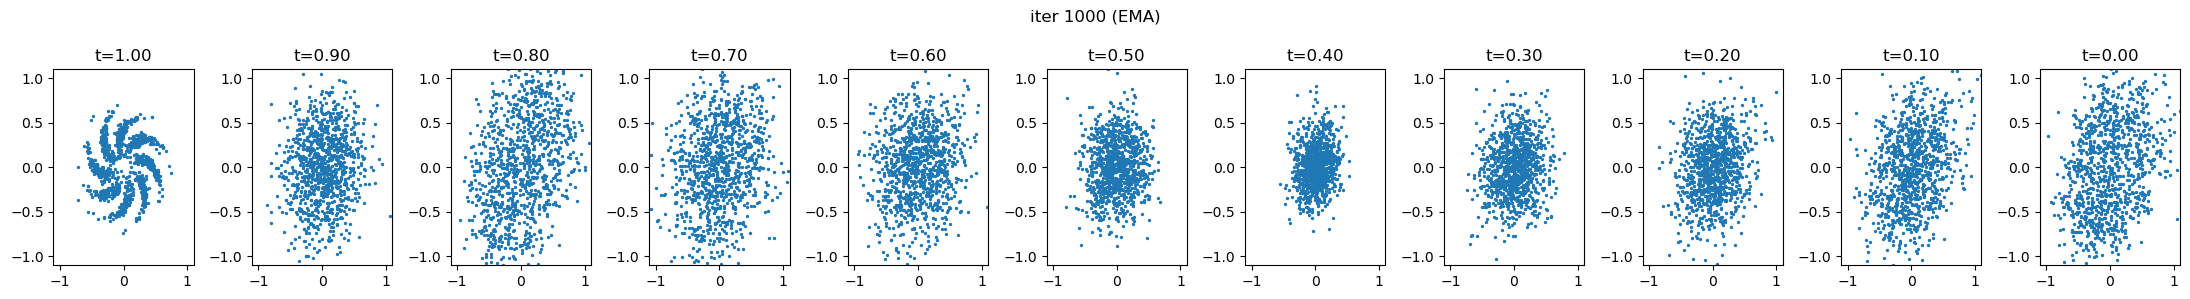

Checkpoint saved @ epoch 1
[Iter 1100] D=1.4066 (real 0.7152 fake 0.6914) | G=0.7060
[Iter 1200] D=1.3739 (real 0.6738 fake 0.7001) | G=0.6997
[Iter 1300] D=1.3936 (real 0.6977 fake 0.6959) | G=0.6951


In [ ]:
def train(args):
    set_seed(args.seed)
    os.makedirs(args.output_dir, exist_ok=True)
    N = int(args.num_timesteps)  
    print(f"N={N}")
    layout = TimeLayout(N, args.k_list, args.epsilon, device=device)
    sampler = Sampler(layout=layout, device=device)
    # ==== Models ====
    netG = MyGenerator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        z_dim=args.z_dim,
        out_dim=args.x_dim,
        layers=[256,256,256],
    ).to(device)
    netD = MyDiscriminator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        layers=[256,256,256],
    ).to(device)

    if args.use_ema:
        from torch_ema import ExponentialMovingAverage
        ema_g = ExponentialMovingAverage(netG.parameters(), decay=args.ema_decay)
        ema_g.to(device)
        print(f"Using EMA with decay = {args.ema_decay}")
    else:
        ema_g = None
        print("Not using EMA")

    # ==== Opt & Sched ====
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas=(args.beta1, args.beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas=(args.beta1, args.beta2))
    schedulerD = optim.lr_scheduler.CosineAnnealingLR(optimizerD, T_max=args.epoch, eta_min=1e-6)
    schedulerG = optim.lr_scheduler.CosineAnnealingLR(optimizerG, T_max=args.epoch, eta_min=1e-6)

    # ==== (Optional) resume ====
    init_iteration = 0
    checkpoint_path = os.path.join(args.output_dir, 'checkpoint.pth')
    if args.resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        netG.load_state_dict(checkpoint['netG_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])
        netD.load_state_dict(checkpoint['netD_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])
        init_iteration = checkpoint['iteration']
        print(f"=> loaded checkpoint (iteration {init_iteration})")
    else:
        if args.resume:
            print(f"=> no checkpoint found at {checkpoint_path}, training from scratch")
        else:
            print(f"=> training from scratch")

    multi_ds = MultiAnchorDataset(
        dist_classes=[Checkerboard, Pinwheel, Checkerboard, Pinwheel],  # 例子：交替分布
        dist_kwargs_list=[{}, {}, {}, {}],
        size=args.batch_size * 1000,
        pairing="independent",
    )
    sb_loader = DataLoader(multi_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)


    n_t = args.num_timesteps
    # ==== utils ====
    softplus = F.softplus

    def r1_penalty(d_out, x_in, gamma=0.05):
        grad = torch.autograd.grad(
            outputs=d_out.sum(), inputs=x_in, create_graph=True,
            retain_graph=True, only_inputs=True
        )[0]
        grad_penalty = (grad.view(grad.size(0), -1).norm(2, dim=1) ** 2).mean()
        return 0.5 * gamma * grad_penalty

    # ==== Train loop ====
    iteration = init_iteration
    print("Start training MSBM...")
    
    for epoch in range(args.epoch):
        for anchors in sb_loader:
            netG.train(); netD.train()
            anchors = tuple(a.to(device) for a in anchors)
            B = anchors[0].size(0)

            # （可选）批内 OT 重配
            if args.use_minibatch_ot:
                # TODO
                raise NotImplementedError("Minibatch OT coupling is not implemented yet.")
            
            #########################
            # Discriminator training
            #########################
            for p in netD.parameters():
                p.requires_grad = True
                
            netD.zero_grad()

            # 采样时间步 - D专用
            t = torch.randint(0, n_t, (B,), device=device, dtype=torch.long)
            
            # 真对
            x_t_real, x_tp1_real = sampler.sample_pair_condition(anchors, t)
            x_t_real.requires_grad = True  # 用于R1
            
            D_real = netD(x_t_real, t, x_tp1_real.detach()).view(-1)
            errD_real = softplus(-D_real).mean()

            # R1正则化
            r1_loss = torch.tensor(0., device=device)
            if args.use_r1 and (iteration % args.lazy_reg == 0):
                r1_loss = r1_penalty(D_real, x_t_real, gamma=args.r1_gamma)
            
            (errD_real + r1_loss).backward()
            
            with torch.no_grad():
                latent_z = torch.randn(B, args.z_dim, device=device)
                x_left_pred = netG(x_tp1_real, t, latent_z)
                # 用对应段的一步后验得到 x_t_fake
                x_t_fake = sampler.posterior_from_pred_left(x_left_pred, x_tp1_real, t)
            
            D_fake = netD(x_t_fake, t, x_tp1_real.detach()).view(-1)
            errD_fake = softplus(D_fake).mean()
            errD_fake.backward()

            errD = errD_real + errD_fake
            nn.utils.clip_grad_norm_(netD.parameters(), max_norm=1.0)
            optimizerD.step()
            
            #########################
            # Generator training
            #########################
            for p in netD.parameters():
                p.requires_grad = False
            
            netG.zero_grad()

            # 重新采样时间步
            t = torch.randint(0, n_t, (B,), device=device, dtype=torch.long)
            
            # 重新生成训练对
            _, x_tp1 = sampler.sample_pair_condition(anchors, t)
            
            latent_z = torch.randn(B, args.z_dim, device=device)
            x_left_pred = netG(x_tp1.detach(), t, latent_z)
            x_t_fake = sampler.posterior_from_pred_left(x_left_pred, x_tp1, t)
            
            output = netD(x_t_fake, t, x_tp1.detach()).view(-1)
            errG = softplus(-output).mean()
            
            errG.backward()
            
            # 梯度裁剪（可选）
            nn.utils.clip_grad_norm_(netG.parameters(), max_norm=1.0)
            
            optimizerG.step()

            # ⭐ 更新EMA
            if args.use_ema:
                ema_g.update()
            
            iteration += 1
            
            if args.print and (iteration % args.print_interval == 0):
                print(f"[Iter {iteration}] D={errD.item():.4f} "
                      f"(real {errD_real.item():.4f} fake {errD_fake.item():.4f}) | "
                      f"G={errG.item():.4f}")
                
            # 可视化（从源出发逆推到目标）
            if args.vis and iteration % args.vis_interval == 0:
                netG.eval()  # 设为eval模式
                
                # 如果使用EMA，用EMA权重；否则用当前权重
                if args.use_ema:
                    with ema_g.average_parameters():
                        with torch.no_grad():
                            visualize_samples(netG, sampler, args, anchors, iteration, device)
                else:
                    with torch.no_grad():
                        visualize_samples(netG, sampler, args, anchors, iteration, device)
                
                netG.train()  # 恢复train模式


        # 每个 epoch 调度 & 保存
        schedulerD.step(); schedulerG.step()
        # ⭐ 保存checkpoint（使用EMA权重）
        if args.save_ckpt:
            if args.use_ema:
                with ema_g.average_parameters():
                    content = {
                        'iteration': iteration,
                        'epoch': epoch,
                        'netG_dict': netG.state_dict(),
                        'optimizerG': optimizerG.state_dict(),
                        'schedulerG': schedulerG.state_dict(),
                        'netD_dict': netD.state_dict(),
                        'optimizerD': optimizerD.state_dict(),
                        'schedulerD': schedulerD.state_dict(),
                    }
            else:
                content = {
                    'iteration': iteration,
                    'epoch': epoch,
                    'netG_dict': netG.state_dict(),
                    'optimizerG': optimizerG.state_dict(),
                    'schedulerG': schedulerG.state_dict(),
                    'netD_dict': netD.state_dict(),
                    'optimizerD': optimizerD.state_dict(),
                    'schedulerD': schedulerD.state_dict(),
                }
            
            torch.save(content, os.path.join(args.output_dir, 'checkpoint.pth'))
            print(f"Checkpoint saved @ epoch {epoch+1}")


args = parse_args(usedefault=True)
args.print = True
args.vis = True
args.save_ckpt = True
args.use_ema = True
args.resume = False
print(args)
train(args)
